In [1]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline

# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt

In [2]:
# Leo la imagen
img = cv.imread('../../Datos/ProyectoEspecializacion/bananas-training/6/m016.jpg')
# La convierto a RGB
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

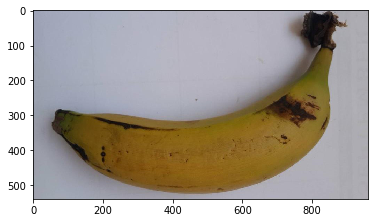

In [3]:
plt.imshow(img)    
plt.show()

In [4]:
# Función para quitar la iluminación de color utilizada al tomar la foto
#-----------------------------------------------------------------------
def whitepatch(image):
    # Separamos canales de color
    #===========================
    B,G,R = cv.split(image) # Separo en canales

    # Calculamos las constantes para el balance
    #==========================================
    maxr=np.amax(R)
    maxb=np.amax(B)
    maxg=np.amax(G)

    #print("Valores máximos por canal:[{},{},{}]".format(maxr,maxb,maxg))

    sr=float(255)/maxr
    sg=float(255)/maxg
    sb=float(255)/maxb

    # print("índices de corrección:[{},{},{}]".format(sr,sg,sb))

    # Balanceamos los canales en relación a la iluminación predominante
    #==================================================================
    R=R*sr
    G=G*sg
    B=B*sb

    # Tenemos que castear a 8bits!
    #============================
    R=R.astype('uint8')
    G=G.astype('uint8')
    B=B.astype('uint8')
    
    image_wp=cv.merge([B,G,R])
    return image_wp

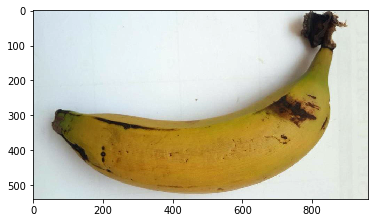

In [5]:
img_wp = whitepatch(img)
plt.imshow(img_wp)
plt.show()

In [8]:
# Probamos segmentar con watershed
#---------------------------------

# Pasar a grises y binarizar
gray = cv.cvtColor(img_wp,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

# Remover ruido
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)

# Definición de puntos que son seguro fondo
sure_bg = cv.dilate(opening,kernel,iterations=3)
# Encontrar puntos que son obrjeto/s
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Encontrar zonas de incertidumbre
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

# Etiquetado de marcadores
ret, markers = cv.connectedComponents(sure_fg)
# Poner en 1 todas los marcadores de manera que el bacground seguro sea 1 y no 0
markers = markers+1
# Regiones de incertidumbre en cero
markers[unknown==255] = 0

# Corremos el algoritmo de watershed y pintamos de rojo lo que segmenta
markers = cv.watershed(img_wp,markers)
img[markers == -1] = [255,0,0]

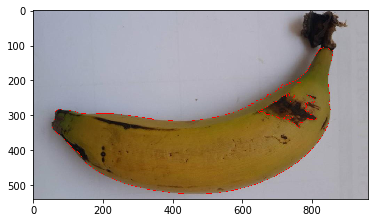

In [12]:
# Mostramos la salida
plt.imshow(img)
plt.show()

#cv.imshow('Watershed',img)
#cv.waitKey(0)
#cv.destroyAllWindows()

In [61]:
# Cambiamos el tamaño a un array de Mx3 (con M el número de píxels). Es decir, un vector de M componentes por canal (R,G,B)
Z = img_wp.reshape((-1,3))
print('Dimensión de la matriz de características (colores): {}'.format(Z.shape))

# convert to np.float32
Z = np.float32(Z)

# Definimos el criterio de detención (Epsilon e iteraciones máximas) y número de clústers (K)
criteria = (cv.TERM_CRITERIA_MAX_ITER + cv.TERM_CRITERIA_EPS, 10, 2.0)
K = 2

# Corremos el algoritmo de K-means con:
# - El criterio de detención predefinido
# - 10 ejecuciones del algoritmo distintos parametros iniciales (devuelve los centros de la corrida que de grupos más compactos)
# - Parámetro de incialización de las semillas (aleatorio)
ret,label,center = cv.kmeans(Z,K,None,criteria,20,cv.KMEANS_RANDOM_CENTERS)

# Mostramos los centros (colores) que forman cada grupo
center = np.uint8(center)
print('Centros: \n {} \n'.format(center))

# La función también devuelve un parámetro de "compactación" basado en las diferencias cuadradas entre las muestras y los centros hallados  
compact = np.uint8(ret)
print('Compactación: \n {} \n'.format(ret))

# Cada píxel que corresponde a un grupo tiene copiado como etiqueta el color al que corresponde. Hacemos un reshape al tamaño original de la matriz de imagen 
img_out = center[label.flatten()]  
img_out = img_out.reshape((img.shape))

Dimensión de la matriz de características (colores): (518400, 3)
Centros: 
 [[221 229 229]
 [149 116  41]] 

Compactación: 
 956208365.4483085 



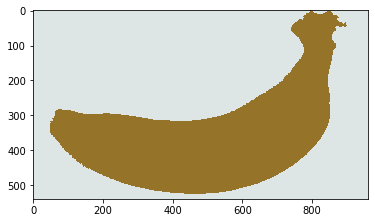

In [62]:
plt.imshow(img_out)    
plt.show()

In [ ]:
# kmeans es medio sensible al parametrizado, por ejemplo para la carpeta 1:
#
# - imagen g034: Anda bien con parámetro TERM_CRITERIA en 2.0, pero no en 1.0 (donde agarra las sombras)
# - imagen g072: Con TERM_CRITERIA en 2.0 le saca un pedazo al interior de la banana donde empezó a madurar (a menos que se le suban las iteraciones)
#
# Pero watershed es menos controlable, entonces por ejemplo para bananas maduras (carpeta 6)
#
# - imagen m016: La parte oscura dentro de la banana la segmenta también.


In [63]:
# A partir de lo anterior obtengo una máscara
#--------------------------------------------
gray = cv.cvtColor(img_out,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,200,255,cv.THRESH_BINARY_INV)

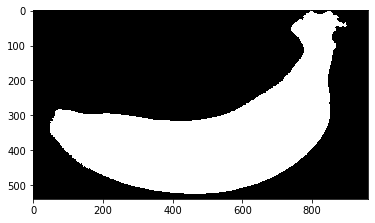

In [64]:
plt.imshow(thresh,cmap='gray')    
plt.show()

In [55]:
dst=cv.repeat(img, 2, 2)

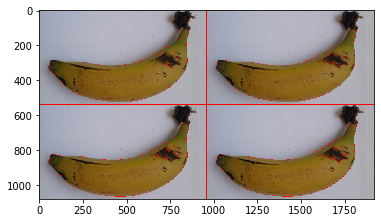

In [56]:
plt.imshow(dst)    
plt.show()

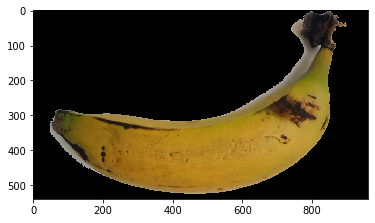

In [65]:
# Imagen segmentada
mask = thresh
img_segmentada = cv.bitwise_and(img_wp, img_wp, mask=mask)
plt.imshow(img_segmentada)    
plt.show()

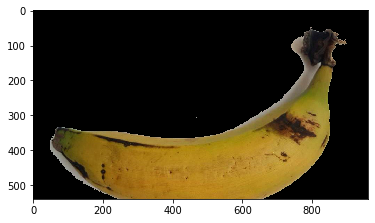

In [68]:
rows,cols,channels = img_segmentada.shape

# Armamos la matriz de traslación de la imagen (tx=100, ty=50)
M = np.float32([[1,0,0],[0,1,50]])

# Aplicamos el desplazamiento (Ojo!. El tercer argumento es el tamaño de la imagen destino)
dst = cv.warpAffine(img_segmentada,M,(cols,rows))
plt.imshow(dst)    
plt.show()

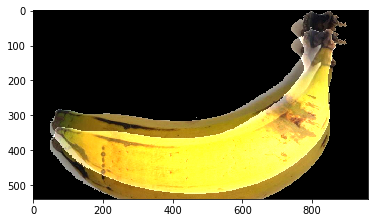

In [69]:
img_suma = cv.addWeighted(img_segmentada,1,dst,1,0)
plt.imshow(img_suma)    
plt.show()